In [51]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

## Data Exploration

In [52]:
df = pd.read_csv('urbandict-word-defs.csv', on_bad_lines='skip')
df.head()

,word_id,word,up_votes,down_votes,author,definition
0,7,Janky,296,255,dc397b2f,Undesirable; less-than optimum.
1,8,slumpin',16,37,dc397b2f,"low down and funky, but [knee deep] enough to ..."
2,9,yayeeyay,19,27,dc397b2f,"affirmation; suggestion of encouragement, appr..."
3,12,hard-core,162,96,d1610749,anything out of our league that can be good or...
4,13,brutal,12,45,40ece1ef,anything that makes you sweat


In [53]:
df.shape

(2580586, 6)

In [54]:
df.isna().sum()

word_id         0
word           35
up_votes        0
down_votes      0
author         36
definition    164
dtype: int64

In [55]:
df = df.dropna()
df.isna().sum()

word_id       0
word          0
up_votes      0
down_votes    0
author        0
definition    0
dtype: int64

In [56]:
#create new df and convert the 'up_votes' and 'down_votes' columns to numeric data types 

ds = df[['word', 'up_votes', 'down_votes', 'definition']].copy()
ds.loc['up_votes'] = pd.to_numeric(ds['up_votes'], errors='coerce')
ds.loc['down_votes'] = pd.to_numeric(ds['down_votes'], errors='coerce')
#Drop NaNs
ds = ds.dropna()

In [57]:
ds.head()

,word,up_votes,down_votes,definition
0,Janky,296.0,255.0,Undesirable; less-than optimum.
1,slumpin',16.0,37.0,"low down and funky, but [knee deep] enough to ..."
2,yayeeyay,19.0,27.0,"affirmation; suggestion of encouragement, appr..."
3,hard-core,162.0,96.0,anything out of our league that can be good or...
4,brutal,12.0,45.0,anything that makes you sweat


In [58]:
ds.shape

(2580352, 4)

In [59]:
ds[ds.down_votes.isin([0, 0.0])] = 1
ds[ds.up_votes.isin([0, 0.0])] = 1
ds = ds[ds.down_votes > 0]
ds = ds[ds.up_votes > 0]
ds['ratio_of_votes'] = ds.up_votes.div(ds.down_votes)
ds['total_votes'] = ds.up_votes.add(ds.down_votes)

In [60]:
# sort by 'ratio_of_votes' in descending order and selects the last 10 rows with the highest ratio of votes.

ds.sort_values(by=['ratio_of_votes'], ascending=False).tail(10)

,word,up_votes,down_votes,definition,ratio_of_votes,total_votes
726789,forgoogle,2.0,1542.0,to get rid of an unpleasant fact by suppressin...,0.001297,1544.0
1985298,chuck norris,4.0,3210.0,the sum of everything awesome and gnarley,0.001246,3214.0
1025378,shadana O'connor,8.0,6851.0,biggest fuckin slut in the world!,0.001168,6859.0
1329616,H-O-L-L-A-N-D,3.0,3068.0,A old fashioned acronymn for: ;; Here ;; Our ;...,0.000978,3071.0
2124760,Chuck-Norris,3.0,3181.0,A Super Human Who Can Do Anything...!,0.000943,3184.0
2055649,Chuck Norris,3.0,3198.0,A man who has 4 biographies written simply on ...,0.000938,3201.0
361718,cudoos,3.0,3916.0,basically just another word for [cool] ;; [wic...,0.000766,3919.0
1587664,cunt,2.0,2905.0,I word that you should never fucking say you s...,0.000688,2907.0
1004198,chuck norris,2.0,3203.0,Chuck Norris is allegedly the only man to ever...,0.000624,3205.0
1287621,Chuck Norris,2.0,3225.0,"The one Supreme Being, the creator and ruler o...",0.000620,3227.0


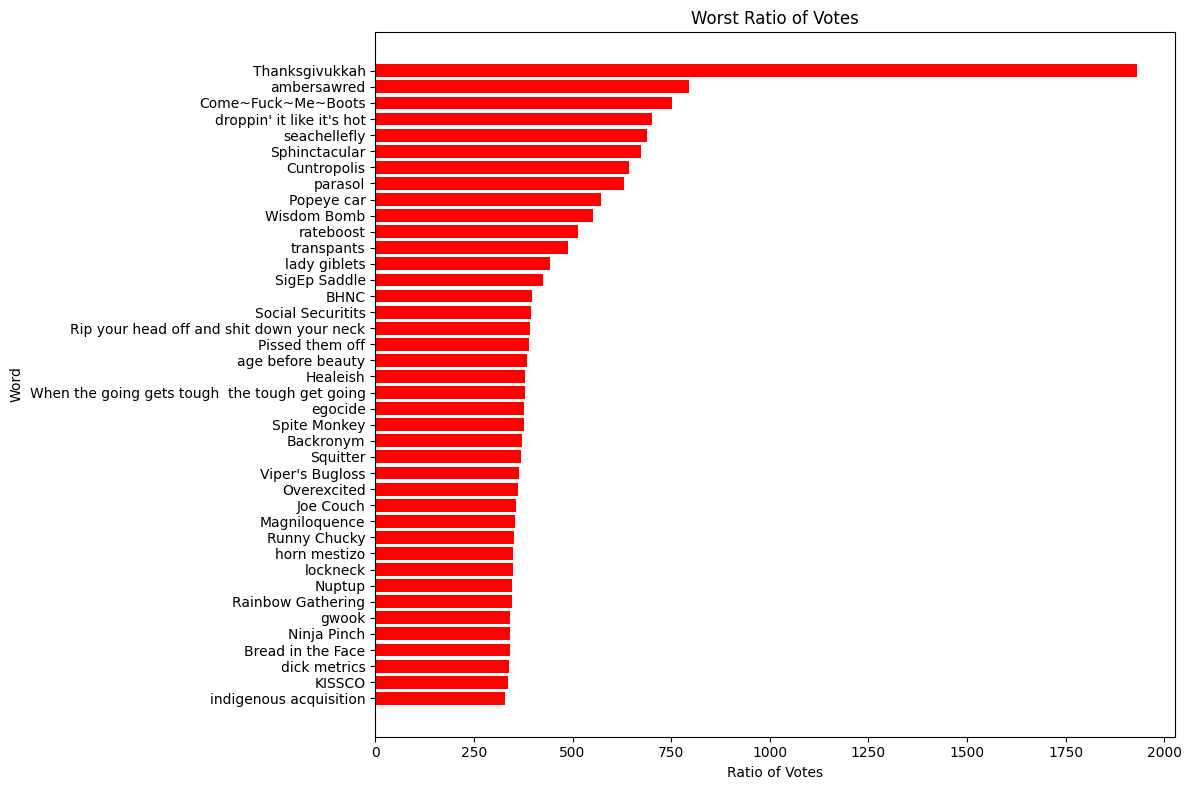

In [61]:
# graphing
import matplotlib.pyplot as plt

ds = ds.sort_values(['ratio_of_votes'])
worst_ratio_words = ds.tail(40)  # Select the bottom 40 words

# Create a bar chart for the worst ratio of votes
plt.figure(figsize=(12, 8))
plt.barh(worst_ratio_words['word'], worst_ratio_words['ratio_of_votes'], color='red')
plt.xlabel('Ratio of Votes')
plt.ylabel('Word')
plt.title('Worst Ratio of Votes')
plt.tight_layout()
plt.show()

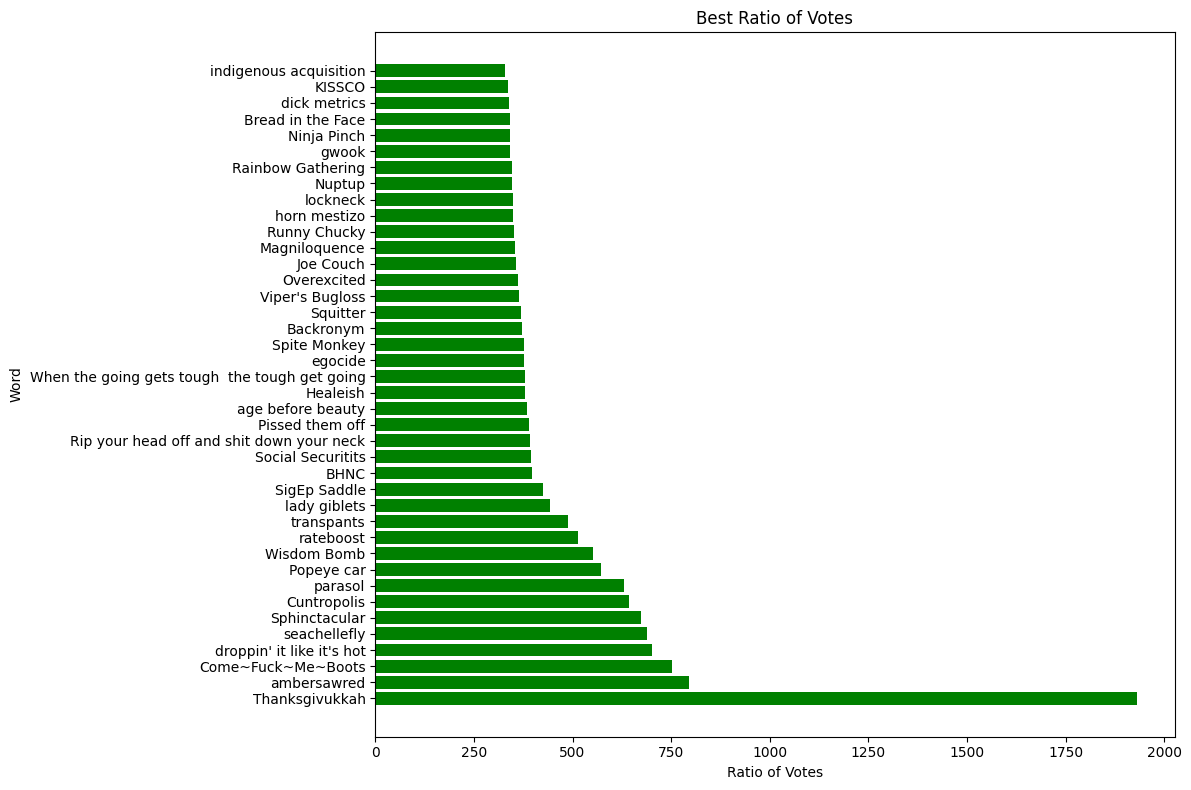

In [62]:
# Sort the DataFrame by 'ratio_of_votes' in descending order for the best ratio
ds = ds.sort_values(['ratio_of_votes'], ascending=False)
best_ratio_words = ds.head(40)  # Select the top 40 words

# Create a bar chart for the best ratio of votes
plt.figure(figsize=(12, 8))
plt.barh(best_ratio_words['word'], best_ratio_words['ratio_of_votes'], color='green')
plt.xlabel('Ratio of Votes')
plt.ylabel('Word')
plt.title('Best Ratio of Votes')
plt.tight_layout()
plt.show()

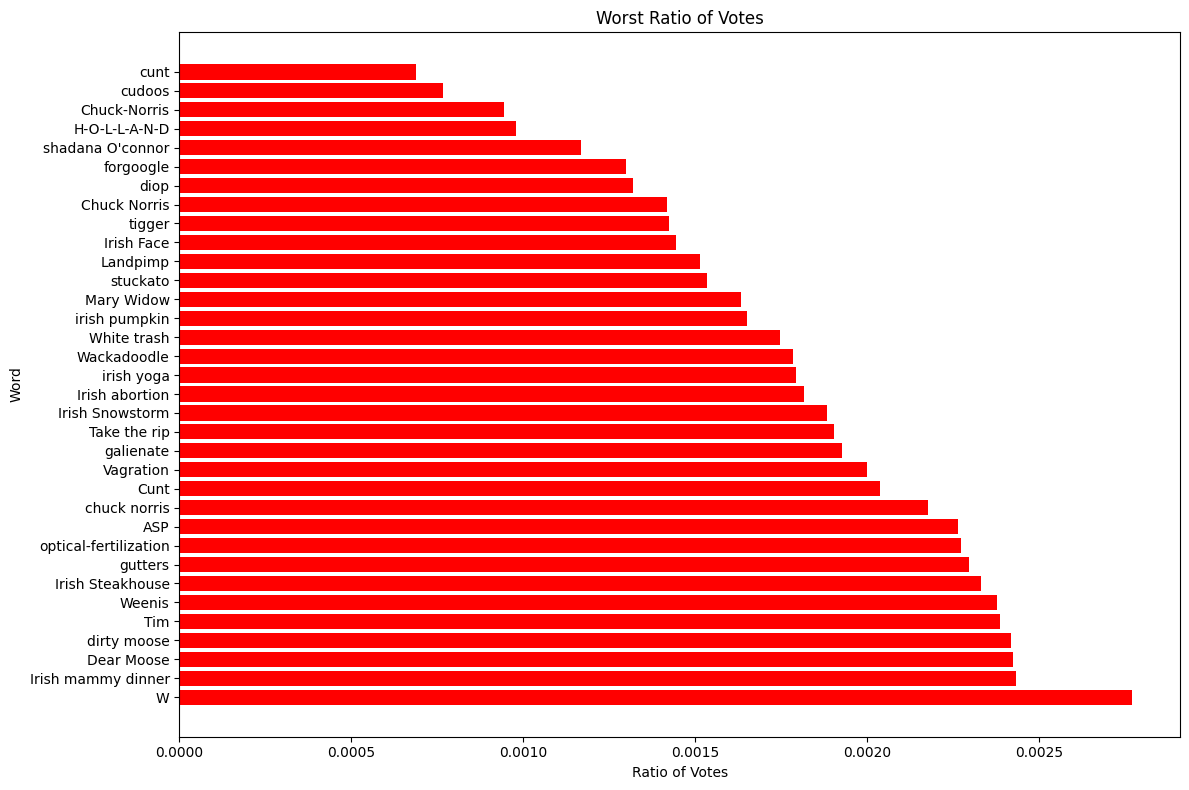

In [63]:
ds = ds.sort_values(['ratio_of_votes'], ascending=False)

# Select the top 40 words with the worst ratio
worst_ratio_words = ds.tail(40)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(worst_ratio_words['word'], worst_ratio_words['ratio_of_votes'], color='red')
plt.xlabel('Ratio of Votes')
plt.ylabel('Word')
plt.title('Worst Ratio of Votes')
plt.tight_layout()
plt.show()


## Sentiment Analysis

In [18]:

#Specific for Stuti's environment since on work laptop
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

In [19]:
# Initialize NLTK stopwords and SentimentIntensityAnalyzer
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

In [22]:
# Define a function for text preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        # Tokenize the text
        words = word_tokenize(text)
        
        # Convert to lowercase
        words = [word.lower() for word in words]
        
        # Remove punctuation and stopwords
        words = [word for word in words if word.isalnum() and word not in stop_words]
        
        return ' '.join(words)
    else:
        return ''

In [ ]:
# Create a new column for preprocessed definitions
df['cleaned_definition'] = df['definition'].apply(preprocess_text)

# Calculate sentiment scores using the SentimentIntensityAnalyzer
df['sentiment_score'] = df['cleaned_definition'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiment based on scores
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

In [ ]:
# Split the dataset for training and testing (you may need more data for better accuracy)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_definition'], df['sentiment'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a simple classifier (Multinomial Naive Bayes)
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_vec)

# Evaluate the classifier
print(classification_report(y_test, y_pred))